# Optimización No Lineal con PyTorch: Método de Punto Interior

Este notebook presenta una implementación detallada del método de punto interior para resolver problemas de programación no lineal con restricciones, utilizando PyTorch y sus capacidades de diferenciación automática. A lo largo del documento, se explica la teoría matemática detrás del método y se proporciona el código correspondiente para su implementación, incluyendo comentarios, docstrings y tipado fuerte. Además, se incluyen gráficas para visualizar el comportamiento del método.


## Introducción

Los problemas de optimización no lineal con restricciones son comunes en diversas áreas de la ingeniería y las ciencias aplicadas. Estos problemas buscan minimizar (o maximizar) una función objetivo sujeta a un conjunto de restricciones de igualdad y desigualdad.

### Problema general de optimización no lineal:

$$

\min_{\mathbf{x}} \quad \& f(\mathbf{x}) \\
\text{sujeto a} \quad \& g_i(\mathbf{x}) \leq 0, \quad i = 1, \dotsc, m \\
\& h_j(\mathbf{x}) = 0, \quad j = 1, \dotsc, p$$

$f(\mathbf{x})$ : Función objetivo a minimizar.$\\$
$g_i(\mathbf{x})$ : Restricciones de desigualdad.$\\$
$h_j(\mathbf{x})$ : Restricciones de igualdad.$\\$
$\mathbf{x} \in \mathbb{R}^n$ : Vector de variables de decisión.$\\$

## Objetivo del Notebook

Implementar el método de punto interior para resolver problemas de optimización no lineal con restricciones utilizando PyTorch, aprovechando sus capacidades de diferenciación automática para calcular gradientes y Hessianas. Además, se proporcionará una explicación matemática detallada y se visualizará el comportamiento del algoritmo mediante gráficas.

### Contenido
1.	Formulación matemática del método de punto interior.
2.	Implementación paso a paso en PyTorch.
3.	Ejemplo práctico con una función objetivo y restricciones específicas.
4.	Análisis de resultados, verificación del cumplimiento de restricciones y visualización gráfica.
5.	Conclusiones.

## 1. Formulación Matemática del Método de Punto Interior

### Función de Barrera

Para manejar las restricciones de desigualdad, se introduce una función de barrera que penaliza la violación de las mismas:


$$\phi(\mathbf{x}) = -\sum_{i=1}^m \ln(-g_i(\mathbf{x}))$$


El problema original se transforma en una serie de problemas sin restricciones:


$$\min_{\mathbf{x}} \quad f(\mathbf{x}) + \frac{1}{t} \phi(\mathbf{x})$$


Donde  $t > 0 $ es un parámetro que controla la influencia de la función de barrera.

## Lagrangiana

Para incorporar las restricciones de igualdad, se utiliza la función Lagrangiana:


$$\mathcal{L}(\mathbf{x}, \boldsymbol{\lambda}) = f(\mathbf{x}) + \frac{1}{t} \phi(\mathbf{x}) + \boldsymbol{\lambda}^\top h(\mathbf{x})$$

	•	 $\boldsymbol{\lambda} \in \mathbb{R}^p $: Multiplicadores de Lagrange asociados a las restricciones de igualdad.

Condiciones de Optimalidad (KKT)

Las condiciones necesarias de optimalidad son:
	1.	Estacionariedad:

$$\nabla f(\mathbf{x}) + \frac{1}{t} \nabla \phi(\mathbf{x}) + J_h(\mathbf{x})^\top \boldsymbol{\lambda} = \mathbf{0}$$

	2.	Factibilidad Primal:

$$h(\mathbf{x}) = \mathbf{0}$$


Donde  $J_h(\mathbf{x})$  es el Jacobiano de las restricciones de igualdad.

Método de Newton

Para resolver el sistema no lineal de ecuaciones dado por las condiciones KKT, se utiliza el método de Newton, resolviendo en cada iteración el siguiente sistema lineal:

$$
\begin{bmatrix}
\nabla^2 \mathcal{L} & J_h(\mathbf{x})^\top \\
J_h(\mathbf{x}) & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\Delta \mathbf{x} \\
\Delta \boldsymbol{\lambda}
\end{bmatrix}
= -
\begin{bmatrix}
\nabla \mathcal{L} \\
h(\mathbf{x})
\end{bmatrix}
$$

## 2. Implementación en PyTorch

A continuación, se presenta la implementación paso a paso del método descrito, utilizando PyTorch. Se incluyen comentarios detallados y docstrings para cada función, así como tipado fuerte mediante anotaciones de tipo.

### Importar Librerías

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple

### Definir la Función Objetivo y las Restricciones

#### Variables de Decisión

In [22]:
# Punto inicial (debe cumplir las restricciones de desigualdad)
x = torch.tensor([1.0, 1.0], requires_grad=True)

#### Función Objetivo

In [23]:
def funcion_objetivo(x: torch.Tensor) -> torch.Tensor:
    """
    Calcula el valor de la función objetivo.

    Args:
        x (torch.Tensor): Vector de variables de decisión.

    Returns:
        torch.Tensor: Valor de la función objetivo en x.
    """
    epsilon = 1e-8  # Para evitar división por cero
    return torch.sin(x[0]) / (x[0] + epsilon) + torch.cos(x[1])

### Restricciones de Desigualdad  $g_i(\mathbf{x}) \leq 0 $

In [24]:
def restricciones_desigualdad(x: torch.Tensor) -> torch.Tensor:
    """
    Calcula los valores de las restricciones de desigualdad.

    Args:
        x (torch.Tensor): Vector de variables de decisión.

    Returns:
        torch.Tensor: Vector de valores de las restricciones de desigualdad.
    """
    return torch.stack([
        x[0] + x[1] - 3,     # g1(x): x0 + x1 - 3 ≤ 0
        -x[0],               # g2(x): -x0 ≤ 0 (x0 ≥ 0)
        -x[1],               # g3(x): -x1 ≤ 0 (x1 ≥ 0)
        x[0] - 2*torch.pi,   # g4(x): x0 - 2π ≤ 0 (x0 ≤ 2π)
        x[1] - 2*torch.pi    # g5(x): x1 - 2π ≤ 0 (x1 ≤ 2π)
    ])

### Restricciones de Igualdad  $h_j(\mathbf{x}) = 0 $

In [25]:
def restricciones_igualdad(x: torch.Tensor) -> torch.Tensor:
    """
    Calcula los valores de las restricciones de igualdad.

    Args:
        x (torch.Tensor): Vector de variables de decisión.

    Returns:
        torch.Tensor: Vector de valores de las restricciones de igualdad.
    """
    return torch.stack([
        x[0] - x[1]  # h(x) = x0 - x1 = 0
    ])

### Función de Barrera Modificada

Se utiliza una penalización cuadrática para manejar las restricciones violadas, asegurando diferenciabilidad.

In [26]:
def funcion_barrera(x: torch.Tensor, t: float) -> torch.Tensor:
    """
    Calcula el valor de la función de barrera para las restricciones de desigualdad.

    Args:
        x (torch.Tensor): Vector de variables de decisión.
        t (float): Parámetro de barrera.

    Returns:
        torch.Tensor: Valor de la función de barrera en x.
    """
    g = restricciones_desigualdad(x)
    epsilon = 1e-8
    # Barrera logarítmica para g < -epsilon
    barrera = -torch.sum(torch.log(-g + epsilon) * (g < -epsilon).float()) / t
    # Penalización cuadrática para g >= -epsilon
    penalizacion = torch.sum(torch.relu(g + epsilon)**2) * t
    return barrera + penalizacion

### Lagrangiana

In [27]:
def lagrangiana(x: torch.Tensor, lambda_eq: torch.Tensor, t: float) -> torch.Tensor:
    """
    Calcula el valor de la función Lagrangiana.

    Args:
        x (torch.Tensor): Vector de variables de decisión.
        lambda_eq (torch.Tensor): Multiplicadores de Lagrange para restricciones de igualdad.
        t (float): Parámetro de barrera.

    Returns:
        torch.Tensor: Valor de la Lagrangiana en x.
    """
    L = funcion_objetivo(x) + torch.dot(lambda_eq, restricciones_igualdad(x)) + funcion_barrera(x, t)
    return L

### Cálculo de Gradientes y Hessianas

#### Gradiente de la Lagrangiana respecto a  $\mathbf{x} $

In [28]:
def calcular_gradientes(x: torch.Tensor, lambda_eq: torch.Tensor, t: float) -> torch.Tensor:
    """
    Calcula el gradiente de la Lagrangiana respecto a x.

    Args:
        x (torch.Tensor): Vector de variables de decisión.
        lambda_eq (torch.Tensor): Multiplicadores de Lagrange para restricciones de igualdad.
        t (float): Parámetro de barrera.

    Returns:
        torch.Tensor: Gradiente de la Lagrangiana.
    """
    L = lagrangiana(x, lambda_eq, t)
    grad_L = torch.autograd.grad(L, x, create_graph=True)[0]
    return grad_L

### Hessiana de la Lagrangiana respecto a  $\mathbf{x}$ 

In [29]:
def calcular_hessiana(x: torch.Tensor, lambda_eq: torch.Tensor, t: float) -> torch.Tensor:
    """
    Calcula la Hessiana de la Lagrangiana respecto a x.

    Args:
        x (torch.Tensor): Vector de variables de decisión.
        lambda_eq (torch.Tensor): Multiplicadores de Lagrange para restricciones de igualdad.
        t (float): Parámetro de barrera.

    Returns:
        torch.Tensor: Hessiana de la Lagrangiana.
    """
    def L_func(x_local):
        return lagrangiana(x_local, lambda_eq, t)
    hess_L = torch.autograd.functional.hessian(L_func, x)
    return hess_L

### Jacobiano de las Restricciones de Igualdad

In [30]:
def calcular_jacobiano_h(x: torch.Tensor) -> torch.Tensor:
    """
    Calcula el Jacobiano de las restricciones de igualdad.

    Args:
        x (torch.Tensor): Vector de variables de decisión.

    Returns:
        torch.Tensor: Jacobiano de las restricciones de igualdad.
    """
    h = restricciones_igualdad(x)
    J_h = torch.autograd.functional.jacobian(restricciones_igualdad, x)
    return J_h  # Forma (número de restricciones, número de variables)

### Paso de Newton Modificado

Se resuelve el sistema KKT para obtener las actualizaciones de  $\mathbf{x}$ y de los multiplicadores de Lagrange $ \boldsymbol{\lambda}$ .

In [31]:
def paso_newton(x: torch.Tensor, lambda_eq: torch.Tensor, t: float) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Realiza un paso del método de Newton para resolver el sistema KKT.

    Args:
        x (torch.Tensor): Vector de variables de decisión actual.
        lambda_eq (torch.Tensor): Multiplicadores de Lagrange actuales.
        t (float): Parámetro de barrera.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Nuevos valores de x y lambda_eq.
    """
    # Calcular gradiente y Hessiana
    grad_L = calcular_gradientes(x, lambda_eq, t)
    hess_L = calcular_hessiana(x, lambda_eq, t)
    
    # Regularizar Hessiana si es necesario
    epsilon = 1e-4
    hess_L += epsilon * torch.eye(len(x))
    
    # Calcular Jacobiano de restricciones de igualdad
    h = restricciones_igualdad(x)
    J_h = calcular_jacobiano_h(x)
    
    # Construir matriz KKT
    n = len(x)
    m = len(h)
    zero_m = torch.zeros((m, m))
    
    KKT_top = torch.cat((hess_L, J_h.T), dim=1)
    KKT_bottom = torch.cat((J_h, zero_m), dim=1)
    KKT_matrix = torch.cat((KKT_top, KKT_bottom), dim=0)
    
    # Construir vector del lado derecho
    rhs = -torch.cat((grad_L, h), dim=0)
    
    # Resolver sistema KKT
    try:
        delta = torch.linalg.solve(KKT_matrix, rhs)
    except RuntimeError:
        # Usar pseudo-inversa si la matriz es singular
        delta = torch.matmul(torch.linalg.pinv(KKT_matrix), rhs)
    
    # Actualizar variables
    delta_x = delta[:n]
    delta_lambda = delta[n:]
    
    x_new = x + delta_x
    lambda_eq_new = lambda_eq + delta_lambda
    
    return x_new.detach().requires_grad_(True), lambda_eq_new.detach().requires_grad_(True)

### Parámetros del Método de Punto Interior

In [32]:
t = 1.0    # Parámetro de barrera inicial
mu = 10.0  # Factor de aumento de t
tol = 1e-6
max_iter = 100

# Inicializar multiplicadores de Lagrange para restricciones de igualdad
lambda_eq = torch.zeros(len(restricciones_igualdad(x)), requires_grad=True)

# Almacenar historial para visualización
historial_x = [x.detach().numpy().copy()]
historial_f = [funcion_objetivo(x).item()]

## 3. Ejecución del Algoritmo

### Bucle Principal

In [34]:
for i in range(max_iter):
    x_prev = x.clone()
    x, lambda_eq = paso_newton(x, lambda_eq, t)
    
    # Almacenar historial
    historial_x.append(x.detach().numpy().copy())
    historial_f.append(funcion_objetivo(x).item())
    
    # Imprimir detalles de la iteración
    g_values = restricciones_desigualdad(x).detach().numpy()
    h_value = restricciones_igualdad(x).detach().numpy()
    if i%5==0:
        print(f"Iteración {i+1}")
        print(f"x = {x.detach().numpy()}")
        print(f"g(x) = {g_values}")
        print(f"h(x) = {h_value}")
        print(f"Función objetivo: {funcion_objetivo(x).item()}")
        print("---")
    
    # Verificar convergencia
    if torch.norm(x - x_prev) < tol:
        print("Convergencia alcanzada.")
        break
    
    # Actualizar t
    t *= mu

Iteración 1
x = [1.5 1.5]
g(x) = [ 0.        -1.5       -1.5       -4.7831855 -4.7831855]
h(x) = [0.]
Función objetivo: 0.7357338666915894
---
Convergencia alcanzada.


### Resultados Finales

In [36]:
# Valores de las restricciones
g_values = restricciones_desigualdad(x).detach().numpy()
h_value = restricciones_igualdad(x).detach().numpy()
print(f"Valores de las restricciones de desigualdad g(x) ≤ 0: {g_values}")
print(f"Valor de la restricción de igualdad h(x) = 0: {h_value}")

# Verificar cumplimiento de restricciones
if np.all(g_values <= 1e-6) and np.all(np.abs(h_value) <= 1e-6):
    print("Todas las restricciones se cumplen.")
else:
    print("Algunas restricciones no se cumplen.")

# Valor final de la función objetivo
print(f"Solución óptima: x = {x.detach().numpy()}")
print(f"Valor óptimo de la función objetivo: {funcion_objetivo(x).item()}")

Valores de las restricciones de desigualdad g(x) ≤ 0: [ 0.        -1.5       -1.5       -4.7831855 -4.7831855]
Valor de la restricción de igualdad h(x) = 0: [0.]
Todas las restricciones se cumplen.
Solución óptima: x = [1.5 1.5]
Valor óptimo de la función objetivo: 0.7357338666915894


## 4. Análisis de Resultados y Visualización

Verificación del Cumplimiento de Restricciones

	•	Restricciones de Desigualdad: Los valores de  $g_i(\mathbf{x})$  deben ser menores o iguales a cero.
	•	Restricciones de Igualdad: El valor de  $h(\mathbf{x})$  debe ser cercano a cero.

Interpretación de la Solución

	•	Variables Óptimas:  $x_0 $ y  $x_1$  deben ser iguales debido a la restricción de igualdad.
	•	Función Objetivo: Se busca minimizar  $f(\mathbf{x})$  dentro de la región factible.

#### Visualización de la Convergencia

##### Gráfica del Valor de la Función Objetivo

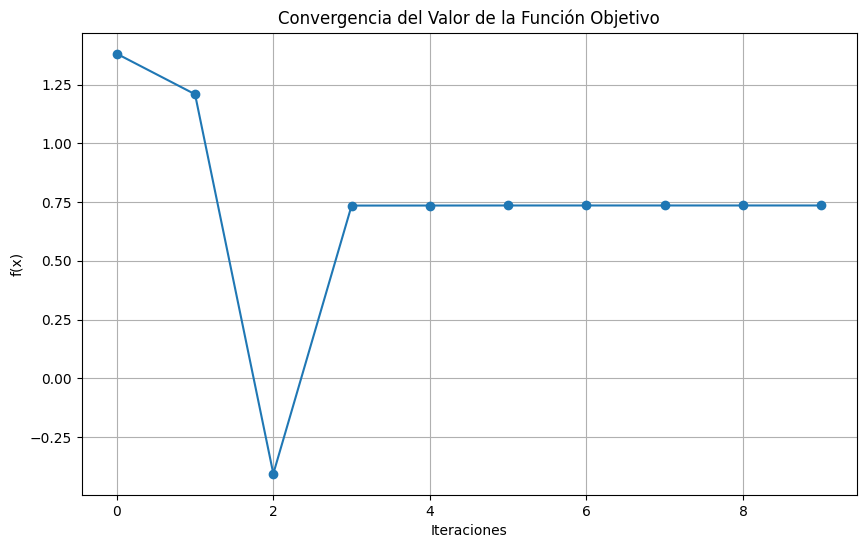

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(historial_f, marker='o')
plt.title('Convergencia del Valor de la Función Objetivo')
plt.xlabel('Iteraciones')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

#### Gráfica de las Trayectorias de las Variables

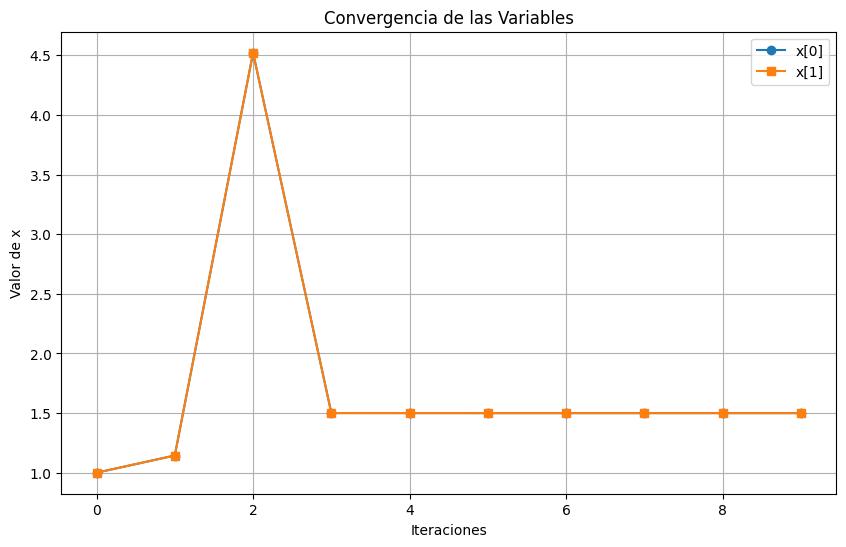

In [38]:
historial_x = np.array(historial_x)

plt.figure(figsize=(10, 6))
plt.plot(historial_x[:, 0], label='x[0]', marker='o')
plt.plot(historial_x[:, 1], label='x[1]', marker='s')
plt.title('Convergencia de las Variables')
plt.xlabel('Iteraciones')
plt.ylabel('Valor de x')
plt.legend()
plt.grid(True)
plt.show()

#### Visualización del Espacio de Solución

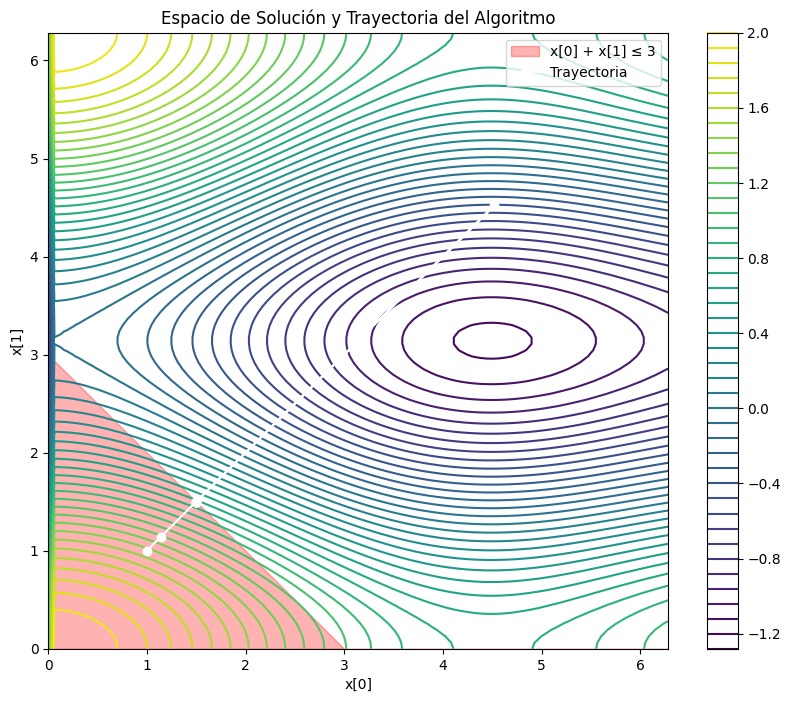

In [39]:
# Crear una cuadrícula de valores para x[0] y x[1]
x0_vals = np.linspace(0, 2*np.pi, 100)
x1_vals = np.linspace(0, 2*np.pi, 100)
X0, X1 = np.meshgrid(x0_vals, x1_vals)
Z = np.sin(X0) / (X0 + 1e-8) + np.cos(X1)

# Graficar la función objetivo y las restricciones
plt.figure(figsize=(10, 8))
contours = plt.contour(X0, X1, Z, levels=50, cmap='viridis')
plt.colorbar(contours)
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.title('Espacio de Solución y Trayectoria del Algoritmo')

# Graficar restricciones de desigualdad
x_line = np.linspace(0, 2*np.pi, 100)
plt.fill_between(x_line, 0, 3 - x_line, color='red', alpha=0.3, label='x[0] + x[1] ≤ 3')
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)

# Graficar trayectoria
plt.plot(historial_x[:, 0], historial_x[:, 1], marker='o', color='white', label='Trayectoria')
plt.legend()
plt.show()

## 5. Conclusiones

	•	Eficacia del Método: El método de punto interior, combinado con el método de Newton y las capacidades de diferenciación automática de PyTorch, permite resolver problemas de optimización no lineal con restricciones de manera eficiente.
	•	Importancia de las Restricciones: La correcta incorporación de las restricciones de igualdad y desigualdad es crucial para obtener soluciones factibles.
	•	Visualización: Las gráficas permiten comprender mejor el comportamiento del algoritmo y verificar visualmente la convergencia hacia la solución óptima.
	•	Ventajas de PyTorch: La facilidad para calcular gradientes y Hessianas con autograd simplifica la implementación de métodos de optimización avanzados.

## Referencias

    •	Nocedal, J., & Wright, S. J. (2006). Numerical Optimization. Springer.
    •	Boyd, S., & Vandenberghe, L. (2004). Convex Optimization. Cambridge University Press.
    •	PyTorch Documentation: Autograd